In [58]:
import numpy as np
np.random.seed(12)
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import os
from scipy.optimize import curve_fit
import pandas as pd

%matplotlib inline

In [59]:
DATA_DIR = '~/Desktop/FTS/cryo_fts_data/scan_data/taurus_band_tests/'
DATA_FILE = '20260204_151759.csv'
data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE), comment = '#')
data = data.drop(index=0)
data

,timestamp,position_mm,x,y,r,theta
1,1.770240e+09,0.096191,1.333789e-05,-0.000023,0.000026,-59.628563
2,1.770240e+09,0.198975,-2.486963e-06,-0.000015,0.000015,-99.718483
3,1.770240e+09,0.297119,-3.000074e-06,-0.000010,0.000010,-107.004227
4,1.770240e+09,0.399902,-1.273792e-05,-0.000006,0.000014,-155.832947
5,1.770240e+09,0.500000,-6.073614e-06,-0.000014,0.000016,-112.890854
...,...,...,...,...,...,...
1958,1.770240e+09,198.721680,7.905173e-06,-0.000017,0.000019,-64.942162
1959,1.770240e+09,198.828857,-2.846976e-07,-0.000011,0.000011,-91.524780
1960,1.770240e+09,198.928223,-7.448060e-06,-0.000001,0.000008,-172.069305
1961,1.770240e+09,199.023926,-5.213137e-06,-0.000025,0.000026,-101.579292


In [60]:
TIMESTAMPS = data['timestamp'].values * u.s
POS = data['position_mm'].values * u.mm
R = data['r'].values * u.V  # Assuming lock-in outputs in V
X = data['x'].values * u.V
Y = data['y'].values * u.V
THETA = data['theta'].values * u.deg

print(f"Total samples: {len(POS)}")
print(f"Position range: {POS.min():.2f} to {POS.max():.2f}")
print(f"Scan duration: {(TIMESTAMPS[-1] - TIMESTAMPS[0]):.2f}")

Total samples: 1962
Position range: 0.10 mm to 199.13 mm
Scan duration: 199.08 s


In [61]:
OPD = POS * 2
I = (R - np.mean(R)).to(u.mV)

In [62]:
OPD_INTERP = np.linspace(OPD.min(), OPD.max(), OPD.size)
I_INTERP = np.interp(OPD_INTERP, OPD, I)

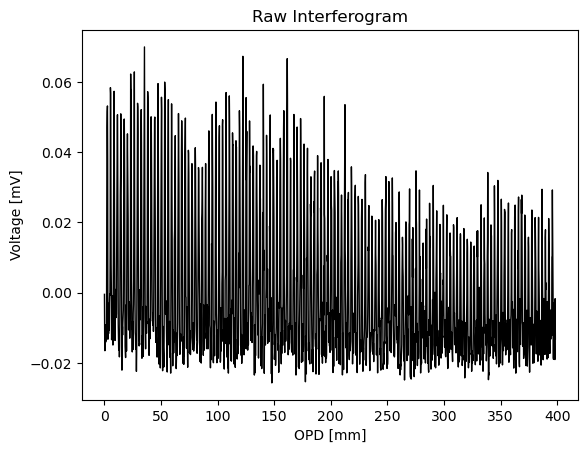

In [63]:
plt.plot(OPD_INTERP, I_INTERP, 'k', lw=1)
plt.title('Raw Interferogram')
plt.ylabel(f'Voltage [{I.unit}]')
plt.xlabel(f'OPD [{OPD.unit}]')
plt.show()

In [64]:
SPECTRUM = np.fft.rfft(I_INTERP)
POWER = np.abs(SPECTRUM)**2

WAVENUMBERS = np.fft.rfftfreq(OPD_INTERP.size, np.diff(OPD_INTERP).mean()).to(1/u.cm)
FREQS = WAVENUMBERS.to(u.GHz, equivalencies=u.spectral())

nyq_freq = (const.c / (2 * np.diff(OPD_INTERP).mean())).to(u.GHz)
print(f"Nyquist frequency: {nyq_freq:.1f}")

Nyquist frequency: 738.4 GHz


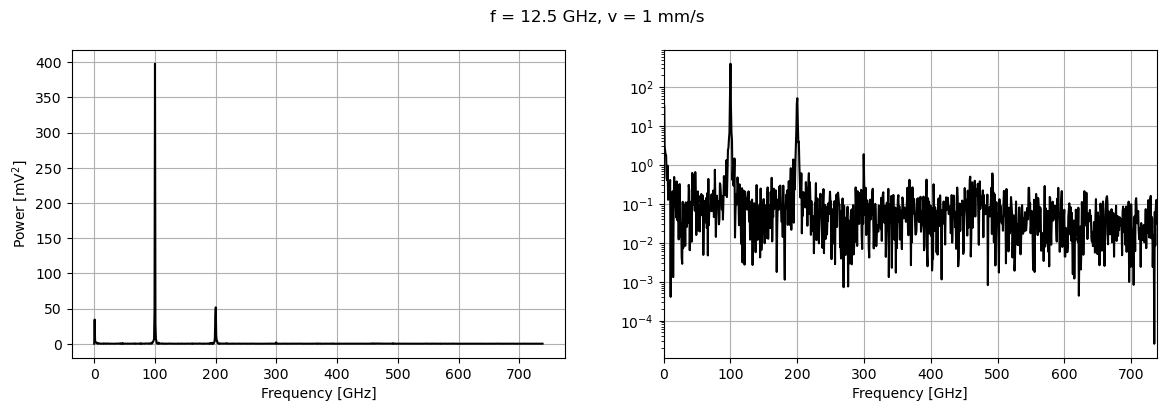

In [65]:
POWER_UNIT = r'$\mathrm{mV^2}$'

%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(FREQS, POWER, color='k', lw=1.5)
axes[0].set_xlabel(rf'Frequency [{FREQS.unit}]')
axes[0].set_ylabel(rf'Power [{POWER_UNIT}]')
#axes[0].set_xlim(60, 100)
axes[0].grid()

axes[1].semilogy(FREQS, POWER, color='k', lw=1.5)
axes[1].set_xlabel(rf'Frequency [{FREQS.unit}]')
axes[1].set_xlim(0, FREQS.value.max())
axes[1].grid()
fig.suptitle("f = 12.5 GHz, v = 1 mm/s")
plt.show()


RESOLUTION: 0.15 mm


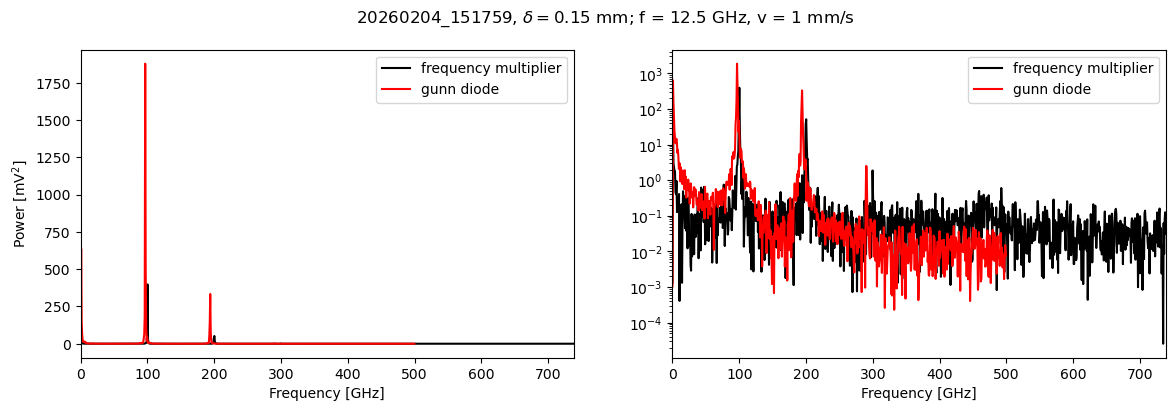

In [66]:
DATA_DIR_gunn = '../../cryo_fts_data/scan_data/gunn_diode/'
DATA_FILE_gunn = '20251210_185512.npz'
data_gunn = np.load(os.path.join(DATA_DIR_gunn, DATA_FILE_gunn))

RES_gunn = data_gunn['RES_mm'] * u.mm
print(f'RESOLUTION: {RES_gunn}')
NSTEPS_gunn = data_gunn['NSTEPS']
R_gunn = data_gunn['R_V'] * u.V
R_rebinned_gunn = R_gunn.reshape(NSTEPS_gunn, 50).mean(axis=1).to(u.mV) # for an older data collection script
I_gunn = (R_rebinned_gunn - np.mean(R_rebinned_gunn))

# the 'ENCODER_POS_mm' key is reading counts for this data file rather than physical position so need to do this work around to get the actual position and OPD:
ENC_RES_gunn = 0.244140625 * u.um
OFFSET_gunn = data_gunn['ENCODER_POS_mm'][0]
POS_gunn = ((data_gunn['ENCODER_POS_mm'] - OFFSET_gunn) * ENC_RES_gunn).to(u.mm)
OPD_gunn = POS_gunn * 2

#dOPD is not constant, so interpolate the interferrogram
dopd_gunn = np.diff(np.sort(OPD_gunn))
dopd_min_gunn = dopd_gunn.min()
OPD_INTERP_gunn = np.linspace(OPD_gunn.min(), OPD_gunn.max(), OPD_gunn.size)
I_INTERP_gunn = np.interp(OPD_INTERP_gunn, OPD_gunn, I_gunn)
# window = np.hanning(OPD.size)
# I_INTERP *= window

SPECTRUM_gunn = np.fft.rfft(I_INTERP_gunn)
POWER_gunn = np.abs(SPECTRUM_gunn)**2
WAVENUMBERS_gunn = np.fft.rfftfreq(OPD_INTERP_gunn.size, np.diff(OPD_INTERP_gunn).mean()).to(1/u.cm)
FREQS_gunn = WAVENUMBERS_gunn.to(u.GHz, equivalencies=u.spectral())

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle(rf'{DATA_FILE.split('.')[0]}, $\delta=${RES_gunn}; f = 12.5 GHz, v = 1 mm/s')

axes[0].plot(FREQS, POWER, color='k', lw=1.5, label = 'frequency multiplier')
axes[0].plot(FREQS_gunn, POWER_gunn, color='r', lw=1.5, label = 'gunn diode')
axes[0].set_xlabel(rf'Frequency [{FREQS.unit}]')
axes[0].set_ylabel(rf'Power [{POWER_UNIT}]')
axes[0].set_xlim(0, FREQS.value.max())
axes[0].legend()


axes[1].semilogy(FREQS, POWER, color='k', lw=1.5, label = 'frequency multiplier')
axes[1].semilogy(FREQS_gunn, POWER_gunn, color='r', lw=1.5, label = 'gunn diode')
axes[1].set_xlabel(rf'Frequency [{FREQS.unit}]')
axes[1].set_xlim(0, FREQS.value.max())
axes[1].legend()
plt.show()